In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
import numpy as np
# from scipy.interpolate import CubicSpline
from scipy.interpolate import CubicSpline
from matplotlib.ticker import ScalarFormatter
from matplotlib import pyplot as plt
from tqdm import tqdm
# from numba import njit, jit
import json

import sys
sys.path.append("./../src")
import scripts as plot_scripts  # plotting functions
plot_scripts.setup_rc_params()


# Let's assume that we are in the DMD folder. Given this is a jupyter notebook that should be reasonable
dmd_path = "./../Results/"
tov_path = "./../TOV_data/"

In [3]:
!ls ./../Results/

DMD_BL.dat                 DMD_apr.dat
DMD_DS_CMF.dat             DMD_sorted_Sly4.dat
DMD_FSUGarnetNStarEOSA.dat Quarkies


In [4]:
# define some useful figure things
dpi = 600 #1200
figsize = (7, 5)  # Goddam that is one big fig. Might make one giant Newton.
save_figures = True
save_location = "./../Plots"

tov_alpha = 0.65
dmd_alpha = 0.8
res_alpha = 0.6
scatter_size = 20
tick_size = 24
axis_label_size = 24
res_axis_label_size = 18
tov_linewidth = 2
dmd_dot_size = 30
res_linewidth = 3
title_size = 24
legend_size = 16

res_width = "60%"
res_height = 2.5

In [5]:
dmd_data_file_names = []
all_of_the_dmd_data = []
for dmd_file in sorted(os.listdir(dmd_path)):
    if (dmd_file[0] != ".") and (dmd_file != "Quarkies"):
        print(dmd_file)
        with open(f"{dmd_path}/{dmd_file}") as f:
            temp_data = json.load(f)
            temp_data["Xdmd"][3] = temp_data["Xdmd"][3][::-1]  # tidal is stored in reverse
        dmd_data_file_names.append(dmd_file)
        all_of_the_dmd_data.append(temp_data)
# all_of_the_dmd_data = np.array(all_of_the_dmd_data)  # this is a dict object

print("")

tov_data_file_names = []
all_of_the_tov_data = []
for tov_file in sorted(os.listdir(tov_path)):
    if (tov_file[0] != ".") and (tov_file != "Quarkies"):
        print(tov_file)
        with open(f"{tov_path}/{tov_file}") as f:
            temp_data = np.loadtxt(f)
        tov_data_file_names.append(tov_file)
        all_of_the_tov_data.append(temp_data)
all_of_the_tov_data = np.transpose(all_of_the_tov_data, (0, 2, 1))  # just personal preference


# manually entered to avoid annoying formatting of strings
eos_file_names = ["BL", "DSCMF", "FSU Garnet", "APR", "SLy4"]

DMD_BL.dat
DMD_DS_CMF.dat
DMD_FSUGarnetNStarEOSA.dat
DMD_apr.dat
DMD_sorted_Sly4.dat

MR_BL.dat
MR_DS_CMF.dat
MR_FSUGarnetNStarEOSA.dat
MR_apr.dat
MR_sorted_Sly4.dat


In [6]:
"""
dmd_run.keys()
>>> dict_keys(['Xdmd', 'b', 'lam', 'omega', 'phi', 'time'])

This is laid out in DMDScript.py, inside of the 
function DMD(). This lays between lines 79 - 138.

Meaning of the keys -- 
- Xdmd: snapshots
- b: eigenvector
- lam: eigenvalues
- omega: the mode -> exp(i omega t)
- phi: A phi = b
- time: the _index_ (not the _time) 
"""

print("")

In [7]:
def the_good_interpolator(x_tov, y_tov, x_dmd):
    # Create a normalized parameter t that corresponds to the original x values
    t_original = np.linspace(0, 1, num=len(x_tov))
    
    # Create cubic splines for original x and y
    cs_x = CubicSpline(t_original, x_tov, bc_type='natural')
    cs_y = CubicSpline(t_original, y_tov, bc_type='natural')
    
    # Create a new parameter t for the new x-values
    t_new = np.linspace(0, 1, num=len(x_dmd))
    
    # Interpolate to find the corresponding y-values for the new x-values
    y_new = cs_y(t_new)
    
    return x_dmd, y_new

In [8]:
def add_subplot_axes(ax,rect,axisbg='w'):
    fig = plt.gcf()
    box = ax.get_position()
    width = box.width
    height = box.height
    inax_position  = ax.transAxes.transform(rect[0:2])
    transFigure = fig.transFigure.inverted()
    infig_position = transFigure.transform(inax_position)    
    x = infig_position[0]
    y = infig_position[1]
    width *= rect[2]
    height *= rect[3]  # <= Typo was here
    #subax = fig.add_axes([x,y,width,height],facecolor=facecolor)  # matplotlib 2.0+
    subax = fig.add_axes([x,y,width,height],axisbg=axisbg)
    x_labelsize = subax.get_xticklabels()[0].get_size()
    y_labelsize = subax.get_yticklabels()[0].get_size()
    x_labelsize *= rect[2]**0.5
    y_labelsize *= rect[3]**0.5
    subax.xaxis.set_tick_params(labelsize=x_labelsize)
    subax.yaxis.set_tick_params(labelsize=y_labelsize)
    return subax

In [9]:
def make_the_axes_look_nice(axis):
    axis.tick_params(which='minor', length=2)
    axis.tick_params(bottom=True, labelbottom=True,
                    top=True, labeltop=False,
                    right=True, labelright=False,
                    left=True, labelleft=True)
    axis.xaxis.set_tick_params(labelsize=tick_size / 1.5)
    axis.xaxis.set_minor_locator(plot_scripts.AutoMinorLocator())  # get minor ticks on x-axis
    axis.xaxis.set_ticks_position('both')  # get minor ticks on top and bottom sides
    axis.yaxis.set_tick_params(labelsize=tick_size / 1.5)
    axis.yaxis.set_ticks_position('both')  # get minor ticks on left and right sides

In [10]:
# # eos_file_names = ['BL', 'DSCMF', 'FSU Garnet', 'APR', 'SLy4']
# eos_file_names = ["BL"]

/var/folders/58/xrmpvhh11mj0pb2kfrznw9qh0000gn/T/ipykernel_96583/586863848.py:249: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


figure saved


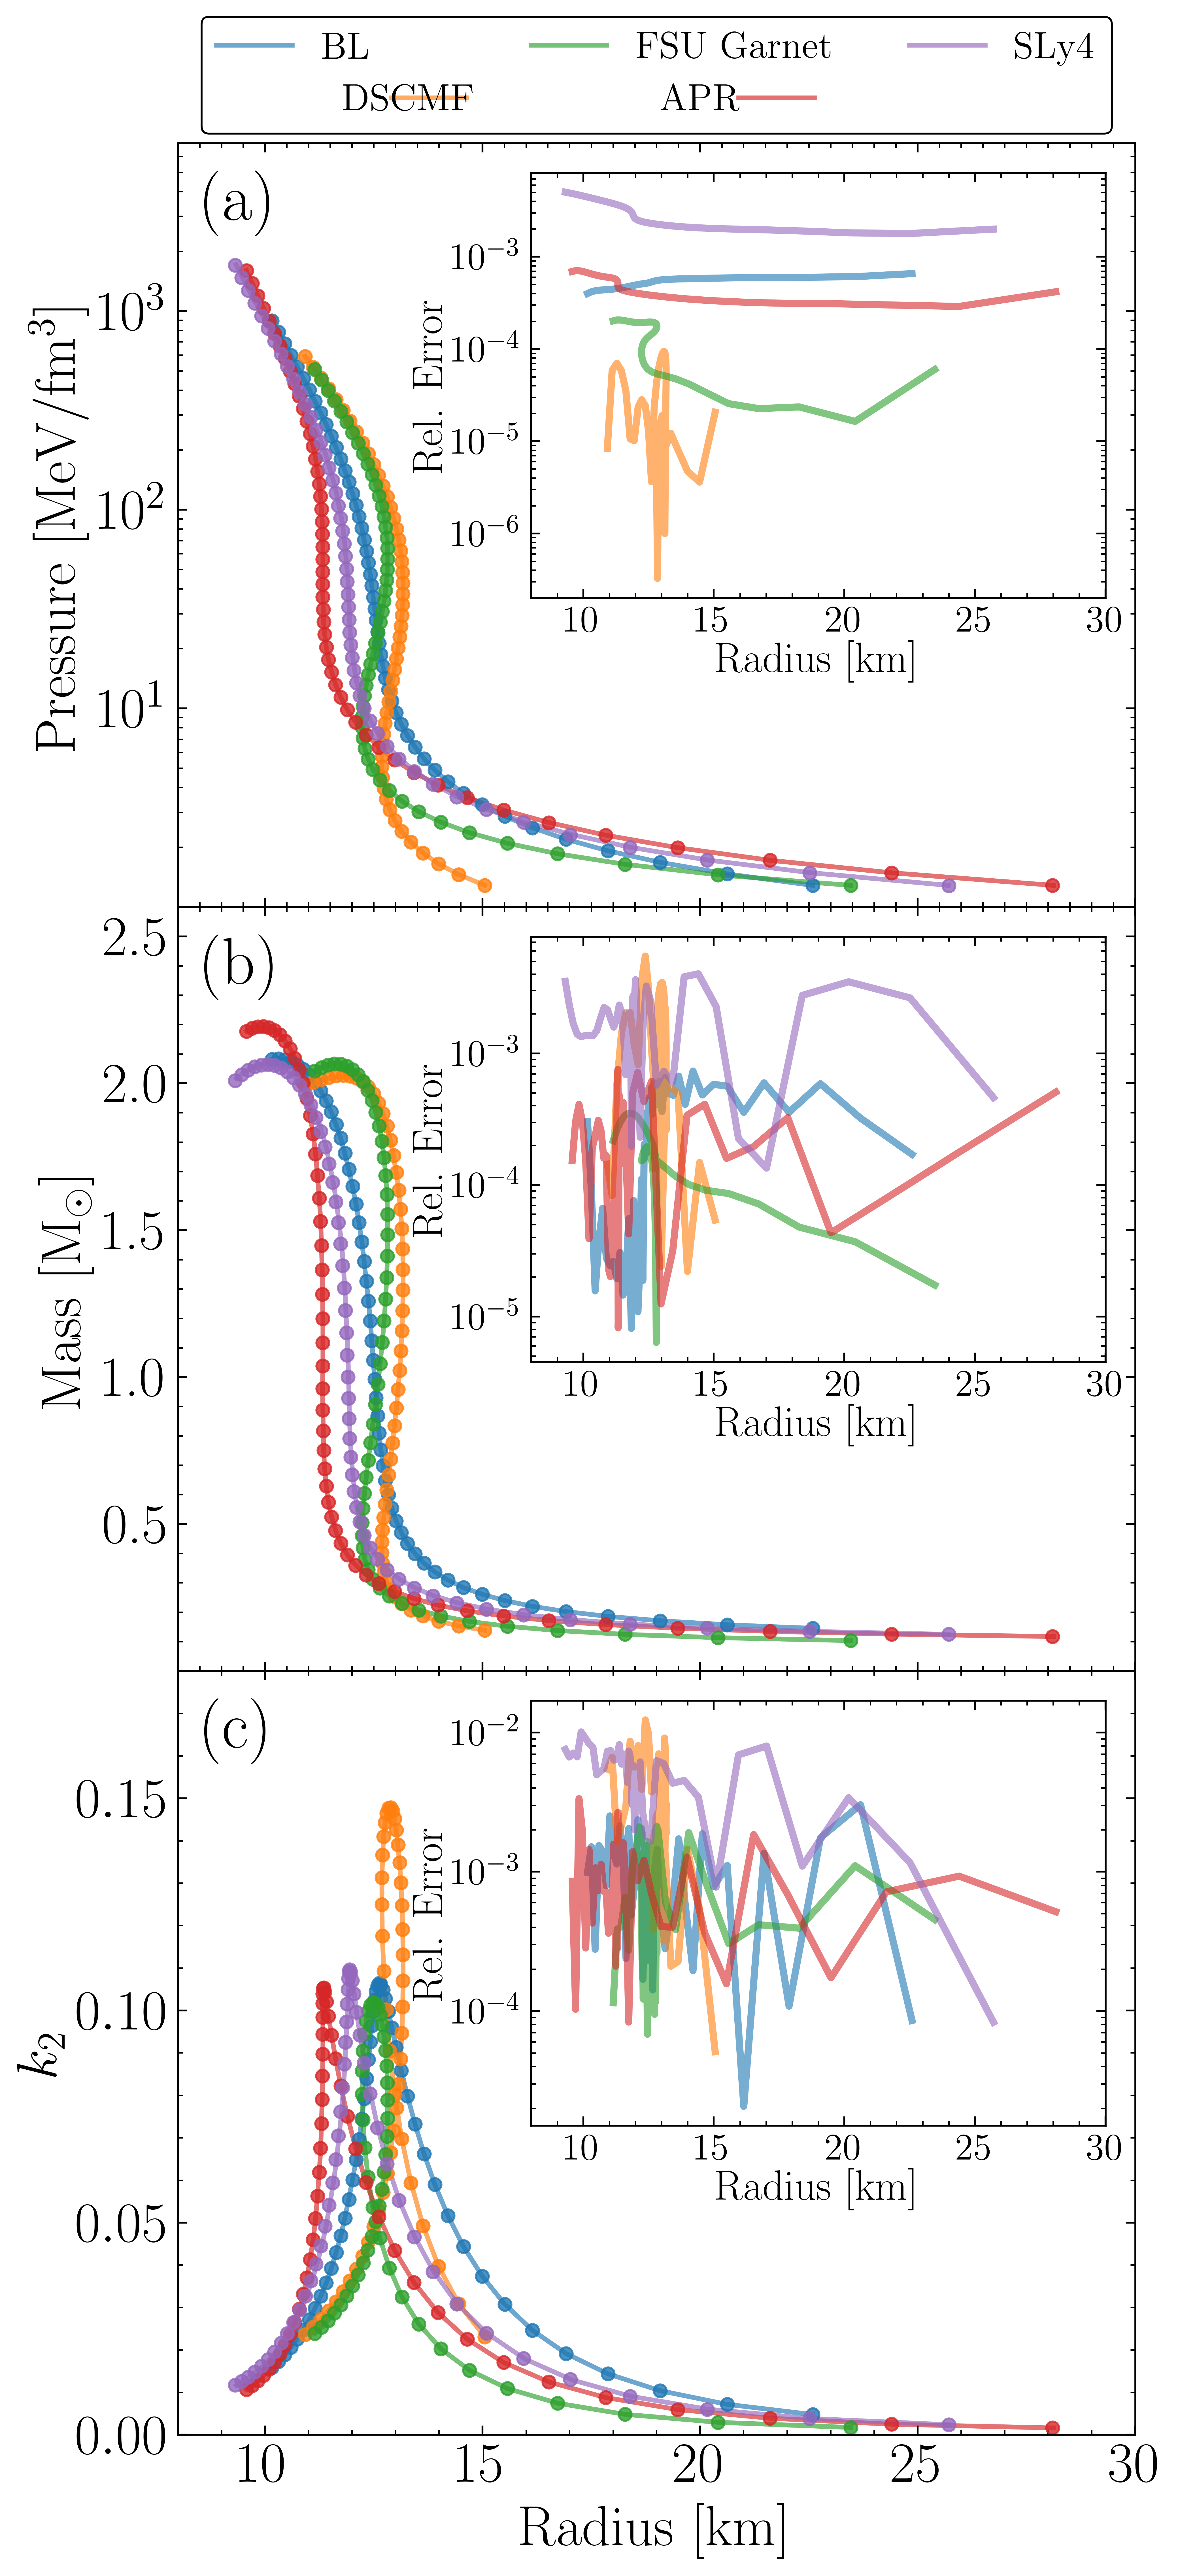

In [29]:
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

def calc_error(FOM, ROM, method="rel"):
    if method == "sym rel":
        error = 2 * np.abs(FOM - ROM) / (np.abs(FOM) + np.abs(ROM))
    elif method == "rel":
        error = np.abs(FOM - ROM) / np.abs(FOM)
    elif method == "abs":
        error = np.abs(FOM - ROM)
    return error

min_R = 8
max_R = 30

fig, ax = plt.subplots(3, 1, dpi=dpi, figsize=(figsize[0], 3 * figsize[1]), constrained_layout=False)

# define the inset exes
# P-R
inset_ax_PR = inset_axes(ax[0],
                         width=res_width,
                         height=res_height,
                         loc="upper right", 
                         borderpad=1.4)
# M-R
inset_ax_MR = inset_axes(ax[1],
                         width=res_width,
                         height=res_height,
                         loc="upper right", 
                         borderpad=1.4)
# T-R
inset_ax_TR = inset_axes(ax[2],
                         width=res_width,
                         height=res_height,
                         loc="upper right", 
                         borderpad=1.4)


colors = ["tab:blue", "tab:orange", "tab:green", "tab:red", "tab:purple"]
lines_plotted = []
for i, eos_name in enumerate(eos_file_names):
    color = colors[i]
    tov_run = all_of_the_tov_data[i]
    dmd_run = all_of_the_dmd_data[i]

    
    dmd_x = dmd_run["Xdmd"][0]
    
    # interpolate the data
    # pressure-radius (in log space)
    PR_x_new, PR_y_new = the_good_interpolator(tov_run[0, :], np.log(tov_run[1, :]), dmd_x)
    PR_y_new = np.exp(PR_y_new)[::-1]
    # mass-radius
    MR_x_new, MR_y_new = the_good_interpolator(tov_run[0, :], tov_run[2, :], dmd_x)
    MR_y_new = MR_y_new[::-1]
    # tidal-radius
    TR_x_new, TR_y_new = the_good_interpolator(tov_run[0, :], tov_run[3, :], dmd_x)
    TR_y_new = TR_y_new[::-1]
    
    # TOV plots
    # the tov results
    test = ax[0].plot(tov_run[0, :], tov_run[1, :], 
               color=color, 
               linewidth=tov_linewidth,
               alpha=tov_alpha, zorder=1, 
               label=f"{eos_name}")
    ax[1].plot(tov_run[0, :], tov_run[2, :], 
               color=color, 
               linewidth=tov_linewidth,
               alpha=tov_alpha, zorder=1,
               label=f"{eos_name}")
    ax[2].plot(tov_run[0, :], tov_run[3, :], 
               color=color, 
               linewidth=tov_linewidth,
               alpha=tov_alpha, zorder=1,
               label=f"{eos_name}")
    lines_plotted.append(test)
    # # the tov results interpolated onto the DMD x-values
    # ax[0].scatter(PR_x_new, PR_y_new, 
    #               color="black", zorder=3, s=5)
    # ax[1].scatter(MR_x_new, MR_y_new, 
    #               color="black", zorder=3, s=5)
    # ax[2].scatter(TR_x_new, TR_y_new, 
    #               color="black", zorder=3, s=10)
    
    # DMD plots
    ax[0].scatter(dmd_x, dmd_run["Xdmd"][1], 
                  color=color, 
                  s=dmd_dot_size, 
                  alpha=dmd_alpha, zorder=2)
    ax[1].scatter(dmd_x, dmd_run["Xdmd"][2], 
                  color=color, 
                  s=dmd_dot_size, 
                  alpha=dmd_alpha, zorder=2)
    ax[2].scatter(dmd_x, dmd_run["Xdmd"][3], 
                  color=color, 
                  s=dmd_dot_size, 
                  alpha=dmd_alpha, zorder=2)
    
    
    # get the inset plots
    
    # first look at the residuals
    method = "sym rel"
    PR_residual = calc_error(PR_y_new, dmd_run["Xdmd"][1], method=method)
    MR_residual = calc_error(MR_y_new, dmd_run["Xdmd"][2], method=method)
    TR_residual = calc_error(TR_y_new, dmd_run["Xdmd"][3], method=method)
    # PR_residual = (PR_y_new - dmd_run["Xdmd"][1]) / PR_y_new
    # MR_residual = (MR_y_new - dmd_run["Xdmd"][2]) / MR_y_new
    # TR_residual = (TR_y_new - dmd_run["Xdmd"][3]) / TR_y_new
    
    # print(dmd_x - np.abs(PR_residual))
    inset_ax_PR.plot(dmd_x, np.abs(PR_residual), 
                     color=color, alpha=res_alpha, linewidth=res_linewidth)
    inset_ax_PR.set_xlabel("Radius [km]", fontsize=res_axis_label_size)
    inset_ax_PR.xaxis.set_label_coords(0.5, -0.1)
    inset_ax_PR.set_xlim(min_R, max_R)
    # inset_ax_PR.set_xticks([10, 20, 30])
    inset_ax_PR.set_xticks([10, 15, 20, 25, 30])
    inset_ax_PR.set_ylabel("Rel. Error", fontsize=res_axis_label_size)
    inset_ax_PR.yaxis.set_label_coords(-0.14, 0.5)
    inset_ax_PR.set_yscale("log")
    make_the_axes_look_nice(inset_ax_PR)
    
    inset_ax_MR.plot(dmd_x, np.abs(MR_residual), 
                     color=color, alpha=res_alpha, linewidth=res_linewidth)
    inset_ax_MR.set_xlabel("Radius [km]", fontsize=res_axis_label_size)
    inset_ax_MR.xaxis.set_label_coords(0.5, -0.1)
    inset_ax_MR.set_xlim(min_R, max_R)
    # inset_ax_MR.set_xticks([10, 20, 30])
    inset_ax_MR.set_xticks([10, 15, 20, 25, 30])
    inset_ax_MR.set_ylabel("Rel. Error", fontsize=res_axis_label_size)
    inset_ax_MR.yaxis.set_label_coords(-0.14, 0.5)
    inset_ax_MR.set_yscale("log")
    make_the_axes_look_nice(inset_ax_MR)
    
    inset_ax_TR.plot(dmd_x, np.abs(TR_residual), 
                     color=color, alpha=res_alpha, linewidth=res_linewidth)
    inset_ax_TR.set_xlabel("Radius [km]", fontsize=res_axis_label_size)
    inset_ax_TR.xaxis.set_label_coords(0.5, -0.1)
    inset_ax_TR.set_xlim(min_R, max_R)
    # inset_ax_TR.set_xticks([10, 20, 30])
    inset_ax_TR.set_xticks([10, 15, 20, 25, 30])
    inset_ax_TR.set_ylabel("Rel. Error", fontsize=res_axis_label_size)
    inset_ax_TR.yaxis.set_label_coords(-0.14, 0.5)
    inset_ax_TR.set_yscale("log")
    make_the_axes_look_nice(inset_ax_TR)

# first plot details
ax[0].set_xlim(min_R, max_R)
ax[0].set_xticks([ 8, 10, 15, 20, 25, 30],
                 ["", "", "", "", "", ""])
ax[0].set_ylabel("Pressure [MeV/fm$^3$]", fontsize=axis_label_size)
ax[0].set_yscale("log")
ax[0].set_yticks([1, 10, 100, 1000], ["", "$10^1$", "$10^2$", "$10^3$"])
ax[0].set_ylim(1, 7e3)
ax[0].tick_params(which='minor', length=2)
ax[0].tick_params(bottom=True, labelbottom=True,
                  top=True, labeltop=False,
                  right=True, labelright=False,
                  left=True, labelleft=True)
ax[0].xaxis.set_tick_params(labelsize=tick_size)
ax[0].xaxis.set_minor_locator(plot_scripts.AutoMinorLocator())  # get minor ticks on x-axis
ax[0].xaxis.set_ticks_position('both')  # get minor ticks on top and bottom sides
ax[0].yaxis.set_tick_params(labelsize=tick_size)
ax[0].yaxis.set_ticks_position('both')  # get minor ticks on left and right sides

# second plot details
ax[1].set_xlim(min_R, max_R)
ax[1].set_xticks([ 8, 10, 15, 20, 25, 30],
                 ["", "", "", "", "", ""])
ax[1].set_ylim(0, 2.6)
ax[1].set_yticks([0, 0.5, 1, 1.5, 2, 2.5],
                 ["", "0.5", "1.0", "1.5", "2.0", "2.5"])
ax[1].set_ylabel(r"Mass [$\rm{M}_{\odot}$]", fontsize=axis_label_size)
ax[1].tick_params(which='minor', length=2)
ax[1].tick_params(bottom=True, labelbottom=True,
                  top=True, labeltop=False,
                  right=True, labelright=False,
                  left=True, labelleft=True)
ax[1].xaxis.set_tick_params(labelsize=tick_size)
ax[1].xaxis.set_minor_locator(plot_scripts.AutoMinorLocator())  # get minor ticks on x-axis
ax[1].xaxis.set_ticks_position('both')  # get minor ticks on top and bottom sides
ax[1].yaxis.set_minor_locator(plot_scripts.AutoMinorLocator())  # get minor ticks on y-axis
ax[1].yaxis.set_tick_params(labelsize=tick_size)
ax[1].yaxis.set_ticks_position('both')  # get log-ticks on left and right sides

# third plot details
ax[2].set_xlim(min_R, max_R)
ax[2].set_xticks([10, 15, 20, 25, 30])
ax[2].set_ylabel("$k_2$", fontsize=axis_label_size)
ax[2].set_ylim(0, 0.18)
ax[2].tick_params(which='minor', length=2)
ax[2].tick_params(bottom=True, labelbottom=True,
                  top=True, labeltop=False,
                  right=True, labelright=False,
                  left=True, labelleft=True)
ax[2].xaxis.set_tick_params(labelsize=tick_size)
ax[2].xaxis.set_minor_locator(plot_scripts.AutoMinorLocator())  # get minor ticks on x-axis
ax[2].xaxis.set_ticks_position('both')  # get minor ticks on top and bottom sides
ax[2].yaxis.set_tick_params(labelsize=tick_size)
ax[2].yaxis.set_minor_locator(plot_scripts.AutoMinorLocator())  # get minor ticks on y-axis
ax[2].yaxis.set_ticks_position('both')  # get log-ticks on left and right sides


# final adjustments
legend = ax[0].legend(fontsize=legend_size, 
                      # title="Equation of State",
                      loc="upper center",   # centered along x
                      ncols=3,
                      bbox_to_anchor=(0.5, 1.205), # 0.5 for x-centering, 1.205 set by-eye to see what was good enough
                      frameon=True,
                      facecolor="white")

# oh my god why was this so hard
for i, t in enumerate(legend.get_texts()):
    if (i == 1) or (i == 3):
        if i == 1:
            shift = 73
        elif i == 3:
            shift = 85
        t.set_position((shift, 0))
for i, line in enumerate(legend.get_lines()):
    if (i == 1) or (i == 3):
        if i == 1:
            shift = -5
        elif i == 3:
            shift = 9
        line.set_xdata(line.get_xdata() + shift + 79)


# label each panel
y_weight = 0.9
x_loc = 8.6

x_min, x_max, y_min, y_max = ax[0].axis()
# ax[0].text(9, np.exp((np.log(y_max) + np.log(y_min)) * 0.5), "(a)", fontsize=28)  # middle
ax[0].text(x_loc, np.exp((np.log(y_max) + np.log(y_min)) * y_weight), "(a)", fontsize=28)  # upper left corner

x_min, x_max, y_min, y_max = ax[1].axis()
# ax[1].text(9, (y_max + y_min) * 0.5, "(b)", fontsize=28)  # middle
ax[1].text(x_loc, (y_max + y_min) * y_weight, "(b)", fontsize=28)  # upper left corner

x_min, x_max, y_min, y_max = ax[2].axis()
# ax[2].text(9, (y_max + y_min) * 0.5, "(c)", fontsize=28)  # middle
ax[2].text(x_loc, (y_max + y_min) * y_weight, "(c)", fontsize=28)  # upper left corner


ax[2].set_xlabel("Radius [km]", fontsize=axis_label_size)
plt.tight_layout()
plt.subplots_adjust(hspace=0.0)

# deal with figure not being nonsense in the pdf file
# Lock the legend in absolute figure coordinates
# legend.set_transform(fig.transFigure)
# legend.set_rasterized(True)  # Rasterize only the legend

if save_figures:
    # plt.savefig(f"{save_location}/3-eos-panel_plot.png", bbox_inches="tight")
    plt.savefig(f"{save_location}/3-eos-panel_plot.pdf", bbox_inches="tight")
    # plt.savefig(f"{save_location}/3-eos-panel_plot.svg", bbox_inches="tight")
    print("figure saved")
plt.show(fig)
